# [ Going Deeper(CV) ] 8. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

✅정의

---
### - 📖목차
* ✔️8-5. 프로젝트 : 개선된 U-Net 모델 만들기
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️8-5. 프로젝트 : 개선된 U-Net 모델 만들기
---
### Step 1. KITTI 데이터셋 수집과 구축


In [ ]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 모듈 설치
%%capture
! pip list | grep albumentations

In [ ]:
# 모듈 로드
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [ ]:
# Image augmentation
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # flip
                    RandomSizedCrop(         # RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      
                Resize(
                    width=224,
                    height=224
                    )
                ])

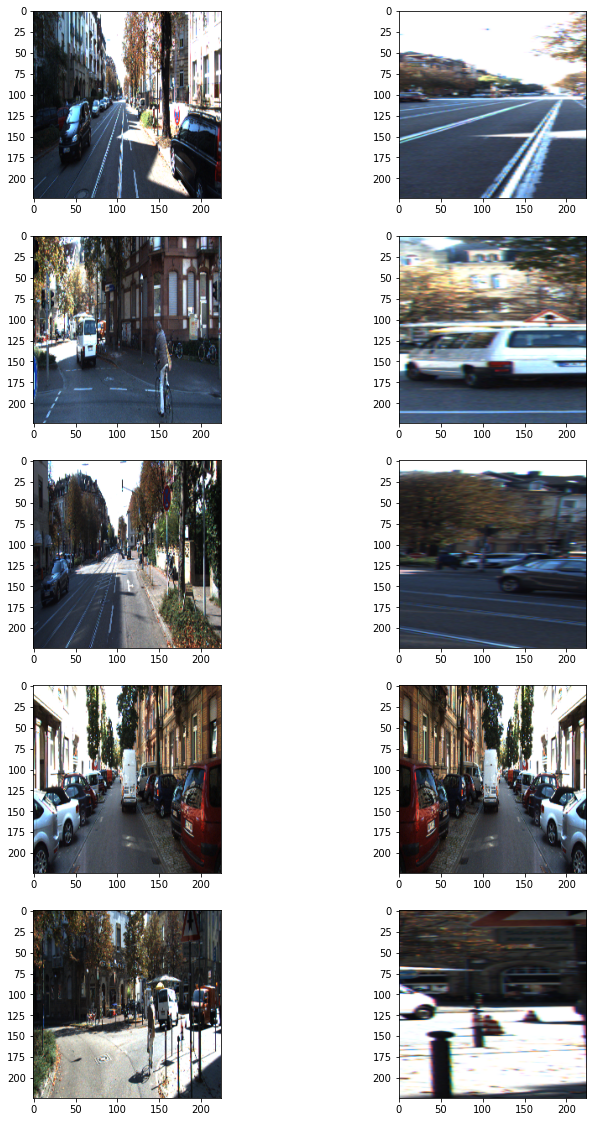

In [ ]:
dir_path = "/content/gdrive/MyDrive/aiffel/gd_08/data/training"

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# augmentation을 적용(5개)  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])
  
plt.show()

> 왼쪽이 원본, 오른쪽이 변형된 이미지들


In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

<br>
<br>

-----

#### - 기본 U-net 모델 생성

In [ ]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [ ]:
unet = build_model()
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

<br>

#### - U-net 모델 학습

In [ ]:
unet_path = "/content/gdrive/MyDrive/aiffel/gd_08/seg_model_unet.h5"

unet = build_model()
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet.save(unet_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 20s 467ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 4s 324ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 4s 325ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 4s 325ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 4s 324ms/step - loss: 0.6908 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 4s 325ms/step - loss: 0.6902 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 4s 324ms/step - loss: 0.6897 - val_loss: 0.6894
Epoch 8/100
11/11 [==============================] - 4s 326ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 4s 324ms/step - loss: 0.6887 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 4s 326ms/step - loss: 0.6881 - val_l

<br>
<br>

-----
### Step 2. U-Net++ 모델의 구현

In [ ]:
def build_unet_plus(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    inputs = Input(input_shape)

    #Contracting Path(encoder 역할을 하는 부분)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv1_2 = Conv2DTranspose(64, (2,2), strides=2, name='up1_2', padding='same')(conv2)
    conv1_2 = concatenate([conv1_2, conv1], name='merge1_2', axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)
    pool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv2_2 = Conv2DTranspose(128, (2,2), strides=2, name='up2_2', padding='same')(conv3)
    conv2_2 = concatenate([conv2_2, conv2], name='merge2_2', axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2)
    pool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)
    
    conv1_3 = Conv2DTranspose(64, (2,2), strides=2, name='up1_3', padding='same')(conv2_2)
    conv1_3 = concatenate([conv1_3, conv1, conv1_2], name='merge1_3', axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)
    pool1_3 = MaxPooling2D(pool_size=(2, 2))(conv1_3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv3_2 = Conv2DTranspose(256, (2,2), strides=2, name='up3_2', padding='same')(conv4)
    conv3_2 = concatenate([conv3_2, conv3], name='merge3_2', axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_2)
    pool3_2 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

    conv2_3 = Conv2DTranspose(128, (2,2), strides=2, name='up2_3', padding='same')(conv3_2)
    conv2_3 = concatenate([conv2_3, conv2, conv2_2], name='merge2_3', axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_3)
    pool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_3)

    conv1_4 = Conv2DTranspose(64, (2,2), strides=2, name='up1_4', padding='same')(conv2_3)
    conv1_4 = concatenate([conv1_4, conv1, conv1_2, conv1_3], name='merge1_4', axis=3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_4)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_4)
    pool1_4 = MaxPooling2D(pool_size=(2, 2))(conv1_4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    
    #Expanding Path(Decoder 역할을 하는 부분)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3, conv3_2 ,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2, conv2_2, conv2_3,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,conv1_2, conv1_3, conv1_4, up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
unet_plus = build_unet_plus()
unet_plus.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_40[0][0]']              
                                )                                                           

In [ ]:
unet_plus.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet_plus.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_plus_path = "/content/gdrive/MyDrive/aiffel/gd_08/seg_model_unet_plus.h5"
unet_plus.save(unet_plus_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


11/11 [==============================] - 14s 847ms/step - loss: 0.6935 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 9s 800ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 9s 801ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 9s 801ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 9s 801ms/step - loss: 0.6908 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 9s 801ms/step - loss: 0.6902 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 9s 803ms/step - loss: 0.6897 - val_loss: 0.6895
Epoch 8/100
11/11 [==============================] - 9s 803ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 9s 802ms/step - loss: 0.6887 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 9s 802ms/step - loss: 0.6881 - val_loss: 0.6879


In [ ]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

<br>
<br>

-----
### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

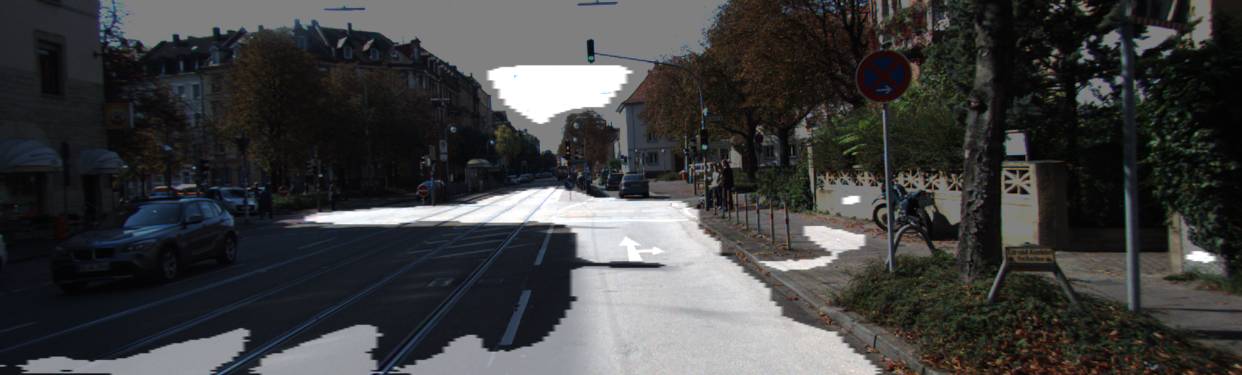

In [ ]:
dir_path = "/content/gdrive/MyDrive/aiffel/gd_08/data/training"

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

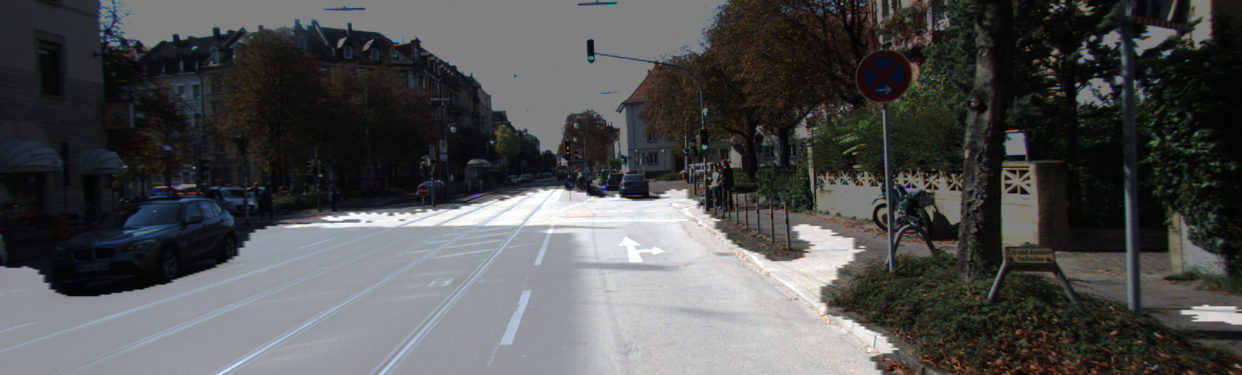

In [ ]:
dir_plus_path = "/content/gdrive/MyDrive/aiffel/gd_08/data/training"

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_plus, 
     test_preproc,
     image_path=dir_plus_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_plus_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1 
output, prediction, target = get_output(
     model_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.900413


0.9004127966976264

Segmentation의 결과로 볼때, 그냥 u-net모델은 위쪽의 하늘도 도로의 영역으로 잡았지만, 플러스의 경우 온전히 도로 자체를 영역으로 삼아서 상대적으로 성능이 더 좋았음을 별도로 증명할 수 있었다. 그와 더불어 IoU 역시 상대적으로 성능면에서 플러스가 더 높은 수치를 보여주는 걸 확인할 수 있었다.(상대적이래 봤자 그림 1장...)

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

u-net++ 의 구조 대체 어떻게 짜야 하는 걸까.... 결국 보다 못해서 쌩으로 가져오기는했는데 결국 찬찬히 뜯어보니까 각각 따로따로 일일히 연결하는 구조라서 오히려 쓰는데 헷갈렸던 기억이 난다. 이걸 반복문 같은 걸로 짜려면 아무래도 알고리즘이 필요할 것 같은데 그렇게까지 스킬이 되진 못하는 거 같다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

어쩄거나 좀 더 촘촘하게 서로 연결되어 있는 구조의 u-net플러스 쪽이 훨씬 성능이 괜찮다는 결과가 나온 건 맞지만, 반대로 더 촘촘하게 하면 더 정밀한 모델로서 동작이 가능할까? 의 의문점이 생겼다. IoU의 동작방식이나, Segmentatoion의 결과를 보면 훨씬 도로 인식하는데 유용해진게 맞아서 납득은 가는데 레이어가 더 깊어질 경우에 어디까지가 한계점인지가 궁금해졌다.(하지만 시간이 오래 걸릴 걸 대비해 내 개인적인 호기심은 나중을 기약하기로..)

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?                                 | KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.                                                        |
| **2** | U-Net++ 모델이 성공적으로 구현되었는가? | U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.                               |
| **3** | U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?                                    | U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다. |

반은 노드에서 가져왔고, 반은 깃허브의 작품이기 때문에 그렇게까지 내가 짠 건 없는 것 같다. 그냥 코드들을 들고올 때 이 코드가 어떻게 쓰이는지, 어디서 오류가 나는지의 여부랑 코랩에서 문제없이 돌아가는지에 대한 체크 정도가 이번에 제출하면서 확인한 지점이 아닌가 싶다.


<br>

#### ▶️ 자기 다짐

요즘에는 직접 코드를 짜기 보다는 일단 제대로 돌아가는 모델이나 코드들을 먼저 선별해서 가져오는 스킬이 더 느는 기분이다. 노드는 중간 과정이 생략되어 있어서 그 중간을 채울 동안은 아무래도 코드를 읽고 이해하는데 더 집중해야겠다는 생각이 든다.

<br>

## ✔️Reference(참고자료)
---
* https://github.com/YejinHwang909/AIFFEL_/blob/188b3999917029a25052d290333a05b58da23c7a/GoingDeeper/GD10_load_segmentation/GD10_load_segmentation.ipynb
* https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=2e5e2023d26851dfa2a52e19016f65f533ef3ce7&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f7173646366642f41494646454c2f326535653230323364323638353164666132613532653139303136663635663533336566336365372f506572736f6e616c2d50726f6a6563742f476f696e67253230446565706572253230284356292f476f696e6725323044656570657225323030352f4744313025354473656d616e7469632532307365676d656e746174696f6e2e53656879756e2e6970796e62&logged_in=false&nwo=qsdcfd%2FAIFFEL&path=Personal-Project%2FGoing+Deeper+%28CV%29%2FGoing+Deeper+05%2FGD10%5Dsemantic+segmentation.Sehyun.ipynb&platform=android&repository_id=433644953&repository_type=Repository&version=99
* https://wsshin.tistory.com/2
* https://jeongwooyeol0106.tistory.com/m/30
* https://medium.com/@codecompose/unet-480d378906fd